### Imports and API Connection

In [1]:
# Imports
import os

# I will be using the spotipy package to access the spotify API:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

# I will be using the Genius API to obtain song lyrics for each song
from lyricsgenius import Genius
import re
import contextlib

# For sentiment analysis, I will be using the natural language toolkit (nltk)
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
# nltk.download('vader_lexicon')

# I created a file called secrets.py with the client id and client secret from my Spotify app.
# These are needed to access the Spotify data:
from secrets import *
from ProjectFunctions import *

# In order to stream the data we'll use the datetime package
from datetime import datetime

# To transform the data, I will use the numpy and pandas packages.
import numpy as np
import pandas as pd

# I will be creating a sql database with sqlalchemy and pymsql
from sqlalchemy import create_engine
import pymysql

# I'll then move that data into a mongo database
import json
import pymongo

# Finally, I'll be using plotnine for the dashboard
from plotnine import *

In [2]:
# The following code is used to access the spotify API using my client id and secret.
client_credentials_manager = SpotifyClientCredentials(client_id=spotify_client_id, client_secret=spotify_client_secret)
spotify = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

# This code connects to the Genius API, which I'll be using to obtain song lyrics.
genius = Genius(genius_api_token)

### Creating a Table with Current Spotify Featured Playlist Information

In [3]:
# currentTime = str(datetime.now()).replace(" ", "T")[:(len(str(datetime.now()).replace(" ", "T")) - 7)]
currentTime = '2022-01-5T23:00:07'

currentFeaturedPlaylists = spotify.featured_playlists(locale=None, country=None, timestamp=currentTime, limit=50, offset=0)['playlists']



# Initialize lists to use to create data frame columns.
playlistIDs = []
playlistNames = []
playlistDescriptions = []
playlistImageURLs = []

# Iterate through each album, adding the id, name, release date, and number of tracks to their respective lists.
for playlist in currentFeaturedPlaylists['items']:
    playlistIDs.append(playlist['id'])
    playlistNames.append(playlist['name'])
    playlistDescriptions.append(playlist['description'])
    playlistImageURLs.append(playlist['images'][0]['url'])
    

# Create a new data frame using the album information.
currentFeaturedPlaylistsTable = pd.DataFrame(data = {
    'playlist_key' : list(range(0,len(playlistIDs))),
    'playlist_id' : playlistIDs,
    'playlist_name' : playlistNames,
    'playlist_description' : playlistDescriptions,
    'playlist_image_url' : playlistImageURLs,
    'featured_dt' : currentTime
})
                         
currentFeaturedPlaylistsTable

,playlist_key,playlist_id,playlist_name,playlist_description,playlist_image_url,featured_dt
0,0,37i9dQZF1DXbcPC6Vvqudd,Night Rain,Pouring rain and occasional rolling thunder.,https://i.scdn.co/image/ab67706f0000000393fe06...,2022-01-5T23:00:07
1,1,37i9dQZF1DX8Sz1gsYZdwj,Classical Sleep,Drift off to these peaceful classical melodies.,https://i.scdn.co/image/ab67706f000000038f5b6b...,2022-01-5T23:00:07
2,2,37i9dQZF1DX0QKpU3cGsyb,Bedroom Jams,Slow jams for the passionate.,https://i.scdn.co/image/ab67706f000000039fec23...,2022-01-5T23:00:07
3,3,37i9dQZF1DWVvXA824aCbn,The Piano Bar,A relaxing atmosphere of jazz piano sounds.,https://i.scdn.co/image/ab67706f00000003ce495a...,2022-01-5T23:00:07
4,4,37i9dQZF1DWZd79rJ6a7lp,Sleep,Gentle ambient piano to help you fall asleep.,https://i.scdn.co/image/ab67706f00000003b70e02...,2022-01-5T23:00:07
5,5,37i9dQZF1DWX3387IZmjNa,B.A.E.,Hip-Hop + R&B: Before. Anything. Else. Cover: ...,https://i.scdn.co/image/ab67706f00000003baace6...,2022-01-5T23:00:07
6,6,37i9dQZF1DX4sWSpwq3LiO,Peaceful Piano,Relax and indulge with beautiful piano pieces,https://i.scdn.co/image/ab67706f00000003ca5a75...,2022-01-5T23:00:07
7,7,37i9dQZF1DWYcDQ1hSjOpY,Deep Sleep,"Soothing, minimalist ambient for deep sleep.",https://i.scdn.co/image/ab67706f00000003c601a6...,2022-01-5T23:00:07
8,8,37i9dQZF1DX2UgsUIg75Vg,Chilled R&B,Chilled R&B jams for your most relaxed moods.,https://i.scdn.co/image/ab67706f000000032b29b4...,2022-01-5T23:00:07
9,9,37i9dQZF1DXbZmKskFbVct,ASMR Sleep Whispers,Soothing ASMR whispers to help you drift off t...,https://i.scdn.co/image/ab67706f000000036c7e86...,2022-01-5T23:00:07


### Using Featured Playlist Table and Spotify API to Create a Table of Currently Featured Tracks

In [4]:
playlistIDs = []
trackIDs = []
trackNames = []
trackArtists = []
trackAlbum = []
trackAddedAt = []
trackDurations = []
trackPopularities = []
trackExplicit = []





for playlistId in currentFeaturedPlaylistsTable['playlist_id']:
    playlistTracks = spotify.playlist_items(playlistId, limit = 50)['items']
    playlistName = currentFeaturedPlaylistsTable
    for trackInfo in playlistTracks:
        track = trackInfo['track']
        playlistIDs.append(playlistId)
        trackAddedAt.append(trackInfo['added_at'])
        trackIDs.append(track['id'])
        trackNames.append(track['name'])
        
        artists = []
        for artistInfo in track['artists']:
            artists.append(artistInfo['name'])
        
        trackArtists.append(artists[0])
        
        trackAlbum.append(track['album']['name'])
        trackDurations.append(track['duration_ms'])
        trackExplicit.append(track['explicit'])
        trackPopularities.append(track['popularity'])

currentFeaturedTracksTable = pd.DataFrame(data = {
    'track_key' : list(range(0,len(trackIDs))),
    'playlist_id' : playlistIDs,
    'track_id' : trackIDs,
    'track_name' : trackNames,
    'track_artists' : trackArtists,
    'track_album' : trackAlbum,
    'track_date_added' : trackAddedAt,
    'track_duration_ms' : trackDurations,
    'Explicit' :  trackExplicit,
    'Popularity' : trackPopularities
})

currentFeaturedTracksTable

,track_key,playlist_id,track_id,track_name,track_artists,track_album,track_date_added,track_duration_ms,Explicit,Popularity
0,0,37i9dQZF1DXbcPC6Vvqudd,4YPTI6iWXVTGIzDLKvInM0,Voltage Dreams,Zinan,Ten Thousand Storms,2022-03-24T17:17:16Z,208000,False,65
1,1,37i9dQZF1DXbcPC6Vvqudd,2pUhY7tWx8egpw2qn84iSi,Slumber Rain,Nature Of Sweden,Rainy Mind,2022-03-24T17:17:16Z,146000,False,66
2,2,37i9dQZF1DXbcPC6Vvqudd,3dHVp4tIryXs62JYtcINhc,Electric Drops,Zinan,Bedtime Thunder,2022-03-24T17:17:16Z,208000,False,61
3,3,37i9dQZF1DXbcPC6Vvqudd,0MAlsJSQfEgP9VjUtNQL8Q,Clarity,Relaxcation,Drizzle & Shower,2022-03-24T17:17:16Z,139691,False,63
4,4,37i9dQZF1DXbcPC6Vvqudd,3g8n6JHQDGGjrE27lAtpvn,Watch The Storm,Distantic,It's A Storm,2022-03-24T17:17:16Z,153065,False,62
...,...,...,...,...,...,...,...,...,...,...
594,594,37i9dQZF1DWUZ5bk6qqDSy,1hrph1qE2yeclQUqzKT8HN,White Noise - Sleep Through the Night,Xella Machina,Sleep Through the Night,2022-04-27T16:44:32Z,204616,False,49
595,595,37i9dQZF1DWUZ5bk6qqDSy,3dxxler1pdW8mMKxsbvrhs,Schlummer Kiste,Noyze Freq,Schlummern,2022-04-27T16:44:32Z,232000,False,53
596,596,37i9dQZF1DWUZ5bk6qqDSy,2bHFzB6CUQSQ6hX9URt9bX,White Noise - Augen Zu,Ozeanus,Augen Zu,2022-04-27T16:44:32Z,199042,False,48
597,597,37i9dQZF1DWUZ5bk6qqDSy,1OnPfzm1vpln863WmYMgt6,Suoni Del Cielo,Molecualar Binary,Fuori Zona,2022-04-27T16:44:32Z,148607,False,50


### Using Featured Track Playlist and Spotify API to Make a Table of Current Track Features

In [5]:
import warnings; warnings.simplefilter('ignore')

currentFeaturedTrackAnalysisTable = currentFeaturedTracksTable[['track_key', 'track_id', 'track_name']]

trackDanceability = []
trackEnergy = []
trackKey = []
trackLoudness = []
trackSpeechiness = []
trackAcousticness = []
trackInstrumentalness = []
trackLiveness = []
trackValence = []
trackTempo = []

for track in currentFeaturedTrackAnalysisTable['track_id']:
    audio_features = spotify.audio_features(track)
    
    try:
        trackDanceability.append(audio_features[0]['danceability'])
        trackEnergy.append(audio_features[0]['energy'])
        trackKey.append(audio_features[0]['key'])
        trackLoudness.append(audio_features[0]['loudness'])
        trackSpeechiness.append(audio_features[0]['speechiness'])
        trackAcousticness.append(audio_features[0]['acousticness'])
        trackInstrumentalness.append(audio_features[0]['instrumentalness'])
        trackLiveness.append(audio_features[0]['liveness'])
        trackValence.append(audio_features[0]['valence'])
        trackTempo.append(audio_features[0]['tempo'])
    
    except:
        trackDanceability.append(None)
        trackEnergy.append(None)
        trackKey.append(None)
        trackLoudness.append(None)
        trackSpeechiness.append(None)
        trackAcousticness.append(None)
        trackInstrumentalness.append(None)
        trackLiveness.append(None)
        trackValence.append(None)
        trackTempo.append(None)
        

currentFeaturedTrackAnalysisTable['Danceability'] = trackDanceability
currentFeaturedTrackAnalysisTable['Energy'] = trackEnergy
currentFeaturedTrackAnalysisTable['Key'] = trackKey
currentFeaturedTrackAnalysisTable['Loudness'] = trackLoudness
currentFeaturedTrackAnalysisTable['Speechiness'] = trackSpeechiness
currentFeaturedTrackAnalysisTable['Acousticness'] = trackAcousticness
currentFeaturedTrackAnalysisTable['Instrumentalness'] = trackInstrumentalness
currentFeaturedTrackAnalysisTable['Liveness'] = trackLiveness
currentFeaturedTrackAnalysisTable['Valence'] = trackValence
currentFeaturedTrackAnalysisTable['Tempo'] = trackTempo

currentFeaturedTrackAnalysisTable

,track_key,track_id,track_name,Danceability,Energy,Key,Loudness,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo
0,0,4YPTI6iWXVTGIzDLKvInM0,Voltage Dreams,0.155,0.629000,1.0,-27.102,0.0690,0.001950,0.00174,0.4040,0.03480,106.743
1,1,2pUhY7tWx8egpw2qn84iSi,Slumber Rain,0.161,1.000000,10.0,-17.037,0.0419,0.914000,0.88100,0.9430,0.00001,81.756
2,2,3dHVp4tIryXs62JYtcINhc,Electric Drops,0.161,0.974000,1.0,-19.947,0.1060,0.000290,0.98800,0.9010,0.00863,129.212
3,3,0MAlsJSQfEgP9VjUtNQL8Q,Clarity,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,3g8n6JHQDGGjrE27lAtpvn,Watch The Storm,0.158,0.542000,1.0,-24.552,0.0805,0.000453,0.94100,0.3910,0.03520,131.109
...,...,...,...,...,...,...,...,...,...,...,...,...,...
594,594,1hrph1qE2yeclQUqzKT8HN,White Noise - Sleep Through the Night,0.145,0.400000,1.0,-33.299,0.0515,0.757000,0.55600,0.1120,0.03020,56.862
595,595,3dxxler1pdW8mMKxsbvrhs,Schlummer Kiste,0.117,0.000282,2.0,-30.617,0.0751,0.939000,0.02830,0.1110,0.00932,74.591
596,596,2bHFzB6CUQSQ6hX9URt9bX,White Noise - Augen Zu,0.142,0.318000,2.0,-33.336,0.0527,0.923000,0.33700,0.1120,0.02030,101.417
597,597,1OnPfzm1vpln863WmYMgt6,Suoni Del Cielo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Integrating Track Lyrics Using the Genius API

In [6]:
def get_lyrics(song, artist):
    try:
        song = genius.search_song(song, artist)
        
        rawLyrics = song.lyrics
        lyrics = re.sub(r"\[.*?\]", "", rawLyrics)
        lyrics = lyrics.strip().split("\n",1)[1].replace('\n', ' ')
        return lyrics
    
    except:
        return None

In [7]:
trackLyricsTable = currentFeaturedTracksTable[["track_key", "track_id", "track_name"]]
songLyrics = []

for index, row in currentFeaturedTracksTable.iterrows():
#     with contextlib.redirect_stdout(None): #This makes sure that we don't see console output during this st
        songLyrics.append(get_lyrics(row['track_name'], row['track_artists']))
    
trackLyricsTable["track_lyrics"] = songLyrics

trackLyricsTable

Searching for "Voltage Dreams" by Zinan...
No results found for: 'Voltage Dreams Zinan'
Searching for "Slumber Rain" by Nature Of Sweden...
Done.
Searching for "Electric Drops" by Zinan...
Done.
Searching for "Clarity" by Relaxcation...
Done.
Searching for "Watch The Storm" by Distantic...
Done.
Searching for "Wake Up When The Storm Is Over" by Ogień...
Done.
Searching for "Wake Up Rain" by Nature Recordings...
Done.
Searching for "Lotus Rain" by Adio...
Done.
Searching for "Dark skies" by LWD Rain...
No results found for: 'Dark skies LWD Rain'
Searching for "Foggy Day - Rain" by NatuREM...
Done.
Searching for "Wellness Rain" by The Mist...
Done.
Searching for "Drops During Dream" by Alois...
Done.
Searching for "Rain Dream" by Golden Drops...
Done.
Searching for "Βροχερές μέρες" by Ο Ήχος της Βροχής...
No results found for: 'Βροχερές μέρες Ο Ήχος της Βροχής'
Searching for "Sonido Dormido" by Dormir Dan...
Done.
Searching for "rain in reykjavik" by pluvia...
No results found for: 'rain

No results found for: 'Ma Mère l'Oye, M. 60: I. Pavane de la belle au bois dormant Maurice Ravel'
Searching for "Strange Light in Her Eyes" by Ever So So Deep...
Done.
Searching for "Grey Cloud Lullaby" by Slow Meadow...
Specified song does not contain lyrics. Rejecting.
Searching for "Water" by Michiel Borstlap...
No results found for: 'Water Michiel Borstlap'
Searching for "Trois Romances sans paroles, Op.17 : 3. Andante moderato" by Gabriel Fauré...
No results found for: 'Trois Romances sans paroles, Op.17 : 3. Andante moderato Gabriel Fauré'
Searching for "Feels Like" by Ella Mai...
Done.
Searching for "Hrs and Hrs" by Muni Long...
Done.
Searching for "Wild Side (feat. Cardi B)" by Normani...
Done.
Searching for "Ur Best Friend (with Kehlani)" by Kiana Ledé...
Done.
Searching for "Another" by Muni Long...
Done.
Searching for "Alone With You" by Alina Baraz...
Done.
Searching for "No Love (with SZA & Cardi B) - Extended Version" by Summer Walker...
Done.
Searching for "Satisfaction"

No results found for: 'Sognando Ancora Giulia De Serio'
Searching for "Ethereal Sleep" by Solvekin...
Done.
Searching for "Becalming Silence" by La Kalon...
Done.
Searching for "Ganymede" by Heddwch...
No results found for: 'Ganymede Heddwch'
Searching for "What Matters Most" by Nathaniel Rembrandt...
Done.
Searching for "Sedang Tidur" by La-Mu...
No results found for: 'Sedang Tidur La-Mu'
Searching for "Tawelwch" by Chieloka...
No results found for: 'Tawelwch Chieloka'
Searching for "Quiet Stars" by Advaitas...
Done.
Searching for "Lenitivo" by Jeanelle Bolduc...
No results found for: 'Lenitivo Jeanelle Bolduc'
Searching for "Sotto La Superficie" by Alcine Sala...
Done.
Searching for "Tauko" by Juhani Ahonen...
No results found for: 'Tauko Juhani Ahonen'
Searching for "Soft Answers" by Neoline Ewing...
No results found for: 'Soft Answers Neoline Ewing'
Searching for "Silent Mind" by Richter Gravitas...
Done.
Searching for "Alterations" by Finleigh...
Done.
Searching for "Sogno Illumin

No results found for: 'pt. 1 Owl Light Stephan Moccio'
Searching for "Silverfog" by Claudio Polle...
No results found for: 'Silverfog Claudio Polle'
Searching for "Zaupanje" by Valbona Ceferin...
No results found for: 'Zaupanje Valbona Ceferin'
Searching for "Last Sunday" by Eddie Jenkins...
Done.
Searching for "Roses" by Brock Hewitt: Stories in Sound...
Done.
Searching for "Zephyr" by Con Alma...
Done.
Searching for "Nocturnal" by Joep Beving...
Done.
Searching for "Pure" by Nel Aique...
Done.
Searching for "Il lago" by Lorenzo Fiore...
Done.
Searching for "Meditabundus" by Kellen Chase...
No results found for: 'Meditabundus Kellen Chase'
Searching for "Rêvasser" by Lucién...
Done.
Searching for "Aquiver" by Milo Liana...
No results found for: 'Aquiver Milo Liana'
Searching for "Travelling" by Ellen Wince...
Done.
Searching for "A Bad Dream That Will Pass Away" by Luke Howard...
Done.
Searching for "Recalibrate" by Floyd Nova...
Done.
Searching for "Mystique" by Cassandra Nestico...


No results found for: 'Removing Negative Energy LunaRexx ASMR'
Searching for "Close Ear to Ear Whispered Countdown to Sleep Pt.2" by HeatheredEffect ASMR...
No results found for: 'Close Ear to Ear Whispered Countdown to Sleep Pt.2 HeatheredEffect ASMR'
Searching for "7 Terrific Triggers, Pt. 1" by TheOneLilium ASMR...
No results found for: '7 Terrific Triggers, Pt. 1 TheOneLilium ASMR'
Searching for "Intense Relaxation Pt.2" by ASMR Glow...
No results found for: 'Intense Relaxation Pt.2 ASMR Glow'
Searching for "Okay, Good, Stipple" by fastASMR...
No results found for: 'Okay, Good, Stipple fastASMR'
Searching for "Violet is BACK to help you fall sleep Pt.1" by RoseASMR...
No results found for: 'Violet is BACK to help you fall sleep Pt.1 RoseASMR'
Searching for "Audio on Spotify, Surfshark" by ASMR Leedah...
No results found for: 'Audio on Spotify, Surfshark ASMR Leedah'
Searching for "Everything is Okay" by LunaRexx ASMR...
No results found for: 'Everything is Okay LunaRexx ASMR'
Searc

Done.
Searching for "Birds in the Forest" by Memorable...
Done.
Searching for "Borneo Jungle Oasis For Deep Sleep With Nature Sound" by Relax Meditate Sleep...
Specified song does not contain lyrics. Rejecting.
Searching for "Evening Drizzle" by Sounds of the Jungle...
Done.
Searching for "Waterfall Constant Roar of a Mountain Waterfall to Reduce Stress. Nature Sounds Relaxing" by Nature Sound Series...
Done.
Searching for "Rain Forest Birds" by Epic Nature Sounds...
Done.
Searching for "Relaxing Crickets And Waterfall" by Natural Sound Makers...
Done.
Searching for "Rainy Day In Forest" by HD Nature Sound Library...
No results found for: 'Rainy Day In Forest HD Nature Sound Library'
Searching for "Walking In The Rainforest" by Manaus...
No results found for: 'Walking In The Rainforest Manaus'
Searching for "Rain Forest Ambience with Medium Distant Bird Chirps and Crickets with Sporadic Close up Exotic Bird Calls and Distant Howler Monkey" by The Hollywood Edge Sound Effects Library...

,track_key,track_id,track_name,track_lyrics
0,0,4YPTI6iWXVTGIzDLKvInM0,Voltage Dreams,None
1,1,2pUhY7tWx8egpw2qn84iSi,Slumber Rain,When Phishlin Phil wants throws his lip ’tis ...
2,2,3dHVp4tIryXs62JYtcINhc,Electric Drops,"THE CALLS Wait, my love, and I'll be with you..."
3,3,0MAlsJSQfEgP9VjUtNQL8Q,Clarity,People need to buy it mainly for getting the ...
4,4,3g8n6JHQDGGjrE27lAtpvn,Watch The Storm,Chorus: Lighting strikes Strikes the surfa...
...,...,...,...,...
594,594,1hrph1qE2yeclQUqzKT8HN,White Noise - Sleep Through the Night,"By: Oliver Stone ""Enjoy yourself -- every da..."
595,595,3dxxler1pdW8mMKxsbvrhs,Schlummer Kiste,None
596,596,2bHFzB6CUQSQ6hX9URt9bX,White Noise - Augen Zu,None
597,597,1OnPfzm1vpln863WmYMgt6,Suoni Del Cielo,None


### Performing Basic Sentiment Analysis on Track Lyrics Using NLTK

In [8]:
trackLyricSentimentTable = trackLyricsTable
SentimentAnalysis = SentimentIntensityAnalyzer()

trackNeg = []
trackNeu = []
trackPos = []
trackComp = []

for lyrics in trackLyricsTable['track_lyrics']:
    try:
        SA = SentimentAnalysis.polarity_scores(lyrics)
        trackNeg.append(SA['neg'])
        trackPos.append(SA['pos'])
        trackNeu.append(SA['neu'])
        trackComp.append(SA['compound'])
    except:
        trackNeg.append(None)
        trackPos.append(None)
        trackNeu.append(None)
        trackComp.append(None)
    
trackLyricSentimentTable['track_negative_sentiment'] = trackNeg
trackLyricSentimentTable['track_neutral_sentiment'] = trackNeu
trackLyricSentimentTable['track_positive_sentiment'] = trackPos
trackLyricSentimentTable['track_compound_sentiment'] = trackComp

trackLyricSentimentTable = trackLyricSentimentTable.drop(columns = ['track_lyrics'])
trackLyricSentimentTable

,track_key,track_id,track_name,track_negative_sentiment,track_neutral_sentiment,track_positive_sentiment,track_compound_sentiment
0,0,4YPTI6iWXVTGIzDLKvInM0,Voltage Dreams,NaN,NaN,NaN,NaN
1,1,2pUhY7tWx8egpw2qn84iSi,Slumber Rain,0.061,0.866,0.073,0.9989
2,2,3dHVp4tIryXs62JYtcINhc,Electric Drops,0.089,0.802,0.110,1.0000
3,3,0MAlsJSQfEgP9VjUtNQL8Q,Clarity,0.025,0.726,0.249,0.9984
4,4,3g8n6JHQDGGjrE27lAtpvn,Watch The Storm,0.080,0.787,0.132,0.9908
...,...,...,...,...,...,...,...
594,594,1hrph1qE2yeclQUqzKT8HN,White Noise - Sleep Through the Night,0.105,0.793,0.102,-0.9999
595,595,3dxxler1pdW8mMKxsbvrhs,Schlummer Kiste,NaN,NaN,NaN,NaN
596,596,2bHFzB6CUQSQ6hX9URt9bX,White Noise - Augen Zu,NaN,NaN,NaN,NaN
597,597,1OnPfzm1vpln863WmYMgt6,Suoni Del Cielo,NaN,NaN,NaN,NaN


### Adding tables to a MySQL Database

In [9]:
def get_dataframe(user_id, pwd, host_name, db_name, sql_query):
    conn_str = f"mysql+pymysql://{user_id}:{pwd}@{host_name}/{db_name}"
    sqlEngine = create_engine(conn_str, pool_recycle=3600)
    connection = sqlEngine.connect()
    dframe = pd.read_sql(sql_query, connection);
    connection.close()
    
    return dframe


def set_dataframe(user_id, pwd, host_name, db_name, df, table_name, pk_column, db_operation):
    conn_str = f"mysql+pymysql://{user_id}:{pwd}@{host_name}/{db_name}"
    
    sqlEngine = create_engine(conn_str, pool_recycle=3600)
    connection = sqlEngine.connect()
    
    if db_operation == "insert":
        df.to_sql(table_name, con=connection, index=False, if_exists='replace')
        sqlEngine.execute(f"ALTER TABLE {table_name} ADD PRIMARY KEY ({pk_column});")
            
    elif db_operation == "update":
        df.to_sql(table_name, con=connection, index=False, if_exists='append')
    
    connection.close()

In [10]:
# Assign Connection Variables for the MySQL Server & Databases
host_name = "localhost"
host_ip = "10.0.0.217"
port = "3306"

user_id = "root"
pwd = "Xander22"
dst_database = "CurrentSpotifyFeatured"
src_database = "AllTimeSpotifyFeatured"

In [11]:
exec_sql = f"CREATE DATABASE `{dst_database}`;"

conn_str = f"mysql+pymysql://{user_id}:{pwd}@{host_name}"
sqlEngine = create_engine(conn_str, pool_recycle=3600)
sqlEngine.execute(exec_sql) #create db
sqlEngine.execute("USE " + dst_database + ";") # select new db

# This will throw an error if the data frame already exists.

In [12]:
db_operation = "insert"

tables = [('currentFeaturedPlaylists', currentFeaturedPlaylistsTable, 'playlist_key'),
          ('currentFeaturedTracks', currentFeaturedTracksTable, 'track_key'),
          ('currentFeaturedTrackAnalysis', currentFeaturedTrackAnalysisTable, 'track_key'),
          ('currentFeaturedTrackLyricSentiment', trackLyricSentimentTable, 'track_key')]

for table_name, dataframe, primary_key in tables:
    set_dataframe(user_id, pwd, host_name, dst_database, dataframe, table_name, primary_key, db_operation)

In [13]:
bashCommand = "mysql --host=localhost --user=root --password=Xander22  < ./CurrentFeaturedJoin.sql"
os.system(bashCommand)

mysql: [Warning] Using a password on the command line interface can be insecure.


0

In [14]:
sql_currentFeaturedTable = "SELECT * FROM CurrentSpotifyFeatured.currentFeatured;"
currentFeatured = get_dataframe(user_id, pwd, host_name, dst_database, sql_currentFeaturedTable).iloc[: , 1:].drop_duplicates()
currentFeatured

,playlist_id,playlist_name,playlist_description,playlist_image_url,featured_dt,track_key,track_id,track_name,track_artists,track_album,...,Instrumentalness,Liveness,Valence,Tempo,Explicit,Popularity,track_negative_sentiment,track_neutral_sentiment,track_positive_sentiment,track_compound_sentiment
0,37i9dQZF1DXbcPC6Vvqudd,Night Rain,Pouring rain and occasional rolling thunder.,https://i.scdn.co/image/ab67706f0000000393fe06...,2022-01-5T23:00:07,0,4YPTI6iWXVTGIzDLKvInM0,Voltage Dreams,Zinan,Ten Thousand Storms,...,0.00174,0.404,0.03480,106.743,0,65,NaN,NaN,NaN,NaN
1,37i9dQZF1DXbcPC6Vvqudd,Night Rain,Pouring rain and occasional rolling thunder.,https://i.scdn.co/image/ab67706f0000000393fe06...,2022-01-5T23:00:07,1,2pUhY7tWx8egpw2qn84iSi,Slumber Rain,Nature Of Sweden,Rainy Mind,...,0.88100,0.943,0.00001,81.756,0,66,0.061,0.866,0.073,0.9989
2,37i9dQZF1DXbcPC6Vvqudd,Night Rain,Pouring rain and occasional rolling thunder.,https://i.scdn.co/image/ab67706f0000000393fe06...,2022-01-5T23:00:07,2,3dHVp4tIryXs62JYtcINhc,Electric Drops,Zinan,Bedtime Thunder,...,0.98800,0.901,0.00863,129.212,0,61,0.089,0.802,0.110,1.0000
3,37i9dQZF1DXbcPC6Vvqudd,Night Rain,Pouring rain and occasional rolling thunder.,https://i.scdn.co/image/ab67706f0000000393fe06...,2022-01-5T23:00:07,3,0MAlsJSQfEgP9VjUtNQL8Q,Clarity,Relaxcation,Drizzle & Shower,...,NaN,NaN,NaN,NaN,0,63,0.025,0.726,0.249,0.9984
4,37i9dQZF1DXbcPC6Vvqudd,Night Rain,Pouring rain and occasional rolling thunder.,https://i.scdn.co/image/ab67706f0000000393fe06...,2022-01-5T23:00:07,4,3g8n6JHQDGGjrE27lAtpvn,Watch The Storm,Distantic,It's A Storm,...,0.94100,0.391,0.03520,131.109,0,62,0.080,0.787,0.132,0.9908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
648,37i9dQZF1DWUZ5bk6qqDSy,White Noise,Welcome to the soothing hum...,https://i.scdn.co/image/ab67706f000000035654f5...,2022-01-5T23:00:07,573,5pU4E6MACvOJPc6eTn4GPg,Sleep White Noise,Scandinavian White Noise,Scandi Noise Vol. 2,...,0.97300,0.112,0.04280,128.781,0,55,0.081,0.810,0.109,1.0000
649,37i9dQZF1DWUZ5bk6qqDSy,White Noise,Welcome to the soothing hum...,https://i.scdn.co/image/ab67706f000000035654f5...,2022-01-5T23:00:07,562,5SJZH9cW2v3SrF3Pher2oP,White Noise Shade 4,Octobas,Shades Of White Noise,...,NaN,NaN,NaN,NaN,0,51,0.055,0.893,0.051,-0.8973
650,37i9dQZF1DWUZ5bk6qqDSy,White Noise,Welcome to the soothing hum...,https://i.scdn.co/image/ab67706f000000035654f5...,2022-01-5T23:00:07,557,6Qa2lVmzgUKjbYf6XIPQEO,The Noisy White Pt 4,Dreams Noises,The Noisy White,...,0.97500,0.112,0.35500,128.854,0,52,0.106,0.809,0.084,-0.9966
651,37i9dQZF1DWUZ5bk6qqDSy,White Noise,Welcome to the soothing hum...,https://i.scdn.co/image/ab67706f000000035654f5...,2022-01-5T23:00:07,583,6jdH1T167abmhAvIz0M3CR,White Home Noise,Rocket FX,White Home Noise,...,NaN,NaN,NaN,NaN,0,50,0.088,0.831,0.082,-0.7214


In [15]:
# Dropping SQL Current Featured Database
exec_sql = f"DROP DATABASE `{dst_database}`;"
sqlEngine.execute(exec_sql) #remove current featured database

In [16]:
# Adding CurrentFeatured.Json to a history directory
currentFeatured.to_json(path_or_buf = ("./CurrentFeaturedHistoryTables/SpotifyFeatured" + currentTime + ".json"),
                       orient = "records")

### Moving Current Data into MongoDB

In [17]:
# pushing dataframe to mongoDB

def get_mongo_dataframe(user_id, pwd, host_name, port, db_name, collection, query):
    '''Create a connection to MongoDB, with or without authentication credentials'''
    if user_id and pwd:
        mongo_uri = 'mongodb://%s:%s@%s:%s/%s' % (username, password, host, port, db_name)
        client = pymongo.MongoClient(mongo_uri)
    else:
        conn_str = f"mongodb://{host_name}:{port}/"
        client = pymongo.MongoClient(conn_str)
    
    '''Query MongoDB, and fill a python list with documents to create a DataFrame'''
    db = client[db_name]
    dframe = pd.DataFrame(list(db[collection].find(query)))
    dframe.drop(['_id'], axis=1, inplace=True)
    client.close()
    
    return dframe

# To start the mongo database, type the following in the terminal:
# brew services start mongodb-community@5.0


# To stop the database, type:
# brew services stop mongodb-community@5.0

In [18]:
host_name = "localhost"
mongo_port = 27017

user_id = "root"
pwd = "Xander22"

src_dbname = "CurrentSpotifyFeatured"

#### Populate Mongo DB with Current Featured Data 

In [19]:
conn_str = f"mongodb://{host_name}:{mongo_port}/"
client = pymongo.MongoClient(conn_str)
db = client[src_dbname]

CurrentFile = "./CurrentFeaturedHistoryTables/SpotifyFeatured" + currentTime + ".json"
AlltimeFile = "SpotifyFeaturedMaster.json"

# for file in json_files:
#     json_file = os.path.join(data_dir, json_files[file])
#     with open(json_file, 'r') as openfile:
#         json_object = json.load(openfile)
#         file = db[file]
#         result = file.insert_many(json_object)
#         #print(f"{file} was successfully loaded.")
        
if os.path.exists(os.path.join(os.getcwd(), "SpotifyFeaturedMaster.json")):
    with open(AlltimeFile, 'r') as openfile:
        json_object = json.load(openfile)
        file = db['AlltimeFeatured']
        result = file.insert_many(json_object)
    
with open(CurrentFile, 'r') as openfile:
    json_object = json.load(openfile)
    fileI = db['currentFeatured']
    fileII = db['AlltimeFeatured']
    resultI = fileI.insert_many(json_object)
    resultII = fileII.insert_many(json_object)
    
    
client.close()

In [20]:
# Checking to see that mongo DB
query = {}
# collection = "currentFeatured"

# mongo_currentFeatured = get_mongo_dataframe(None, None, host_name, mongo_port, src_dbname, collection, query)
# mongo_currentFeatured

In [21]:
# Checking to see that mongo DB
collection = "AlltimeFeatured"
AllTimeFeatured = get_mongo_dataframe(None, None, host_name, mongo_port, src_dbname, collection, query)
AllTimeFeatured

,playlist_id,playlist_name,playlist_description,playlist_image_url,featured_dt,track_key,track_id,track_name,track_artists,track_album,...,Instrumentalness,Liveness,Valence,Tempo,Explicit,Popularity,track_negative_sentiment,track_neutral_sentiment,track_positive_sentiment,track_compound_sentiment
0,37i9dQZF1DX4xuWVBs4FgJ,Dinner with Friends,Dinner with Friends? Here's the perfect playlist.,https://i.scdn.co/image/ab67706f00000003c5704d...,2022-05-11T18:24:05,1,0c9Vl4iBLhsmzttG0X4XhY,Blackbird,James Smith,Blackbird,...,0.00819,0.1830,0.1760,167.855,0,54,0.129,0.817,0.053,-0.8860
1,37i9dQZF1DX4xuWVBs4FgJ,Dinner with Friends,Dinner with Friends? Here's the perfect playlist.,https://i.scdn.co/image/ab67706f00000003c5704d...,2022-05-11T18:24:05,0,4rqe64hyIfoMfiBcvVZqfT,Head And Heart On Fire,LÉON,Head And Heart On Fire,...,0.00000,0.0938,0.2440,125.913,0,0,0.061,0.836,0.103,0.8020
2,37i9dQZF1DX4xuWVBs4FgJ,Dinner with Friends,Dinner with Friends? Here's the perfect playlist.,https://i.scdn.co/image/ab67706f00000003c5704d...,2022-05-11T18:24:05,2,0E4Y1XIbs8GrAT1YqVy6dq,Afterglow,Ed Sheeran,Afterglow,...,0.00000,0.3280,0.2730,110.184,0,75,0.068,0.773,0.159,0.9782
3,37i9dQZF1DWTwnEm1IYyoj,Soft Pop Hits,Listen to easy songs from your favorite artist...,https://i.scdn.co/image/ab67706f000000036ace01...,2022-05-11T18:24:05,457,0E4Y1XIbs8GrAT1YqVy6dq,Afterglow,Ed Sheeran,Afterglow,...,0.00000,0.3280,0.2730,110.184,0,75,0.068,0.773,0.159,0.9782
4,37i9dQZF1DX4xuWVBs4FgJ,Dinner with Friends,Dinner with Friends? Here's the perfect playlist.,https://i.scdn.co/image/ab67706f00000003c5704d...,2022-05-11T18:24:05,3,6Lx8iWqYzIT5hnuriaGCY9,Moonlight,Lilly Ahlberg,Moonlight,...,0.00000,0.1640,0.4330,82.979,0,50,0.080,0.850,0.071,0.3034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1729,37i9dQZF1DWUZ5bk6qqDSy,White Noise,Welcome to the soothing hum...,https://i.scdn.co/image/ab67706f000000035654f5...,2022-01-5T23:00:07,573,5pU4E6MACvOJPc6eTn4GPg,Sleep White Noise,Scandinavian White Noise,Scandi Noise Vol. 2,...,0.97300,0.1120,0.0428,128.781,0,55,0.081,0.810,0.109,1.0000
1730,37i9dQZF1DWUZ5bk6qqDSy,White Noise,Welcome to the soothing hum...,https://i.scdn.co/image/ab67706f000000035654f5...,2022-01-5T23:00:07,562,5SJZH9cW2v3SrF3Pher2oP,White Noise Shade 4,Octobas,Shades Of White Noise,...,NaN,NaN,NaN,NaN,0,51,0.055,0.893,0.051,-0.8973
1731,37i9dQZF1DWUZ5bk6qqDSy,White Noise,Welcome to the soothing hum...,https://i.scdn.co/image/ab67706f000000035654f5...,2022-01-5T23:00:07,557,6Qa2lVmzgUKjbYf6XIPQEO,The Noisy White Pt 4,Dreams Noises,The Noisy White,...,0.97500,0.1120,0.3550,128.854,0,52,0.106,0.809,0.084,-0.9966
1732,37i9dQZF1DWUZ5bk6qqDSy,White Noise,Welcome to the soothing hum...,https://i.scdn.co/image/ab67706f000000035654f5...,2022-01-5T23:00:07,583,6jdH1T167abmhAvIz0M3CR,White Home Noise,Rocket FX,White Home Noise,...,NaN,NaN,NaN,NaN,0,50,0.088,0.831,0.082,-0.7214


In [22]:
# Adding AllTimeFeatured.json to a history directory
AllTimeFeatured.to_json(path_or_buf = ("./AlltimeFeaturedHistoryTables/AllTimeFeatured" + currentTime + ".json"),
                       orient = "records")

# Writing AllTimeFeatured.json to a the current directory
AllTimeFeatured.to_json(path_or_buf = ("./SpotifyFeaturedMaster.json"),
                       orient = "records")

In [23]:
result = client.drop_database("CurrentSpotifyFeatured")


print("Return Value: ", result)
print("Databases: ", client.list_database_names())
print("Collections: ", db.list_collection_names())

Return Value:  None
Databases:  ['admin', 'config', 'local']
Collections:  []


### Creating Dashboard

In [24]:
AllTimeFeatured.columns

Index(['playlist_id', 'playlist_name', 'playlist_description',
       'playlist_image_url', 'featured_dt', 'track_key', 'track_id',
       'track_name', 'track_artists', 'track_album', 'track_date_added',
       'track_duration_ms', 'Danceability', 'Energy', 'Key', 'Loudness',
       'Speechiness', 'Acousticness', 'Instrumentalness', 'Liveness',
       'Valence', 'Tempo', 'Explicit', 'Popularity',
       'track_negative_sentiment', 'track_neutral_sentiment',
       'track_positive_sentiment', 'track_compound_sentiment'],
      dtype='object')

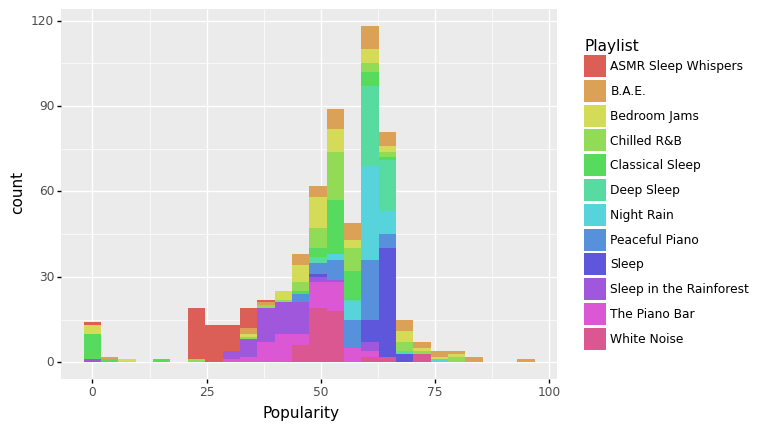

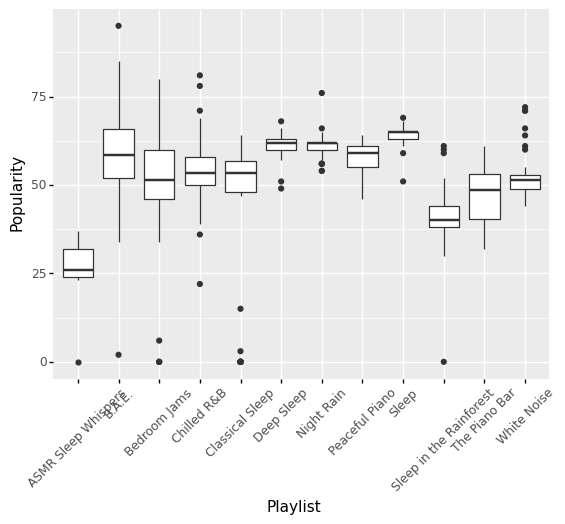

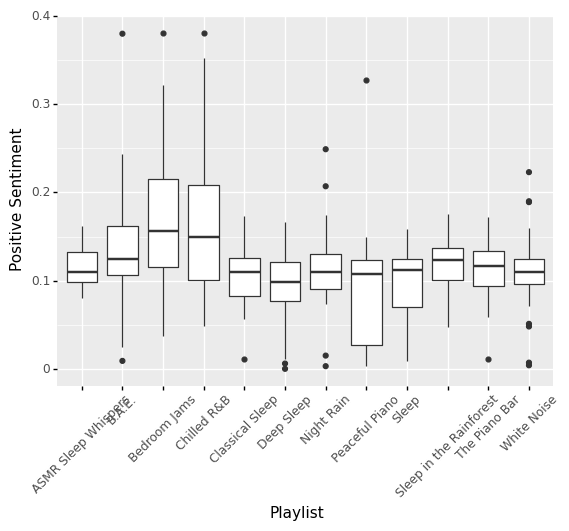

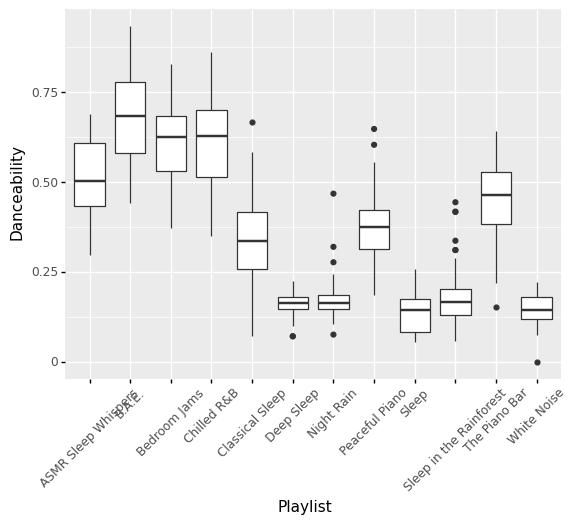

In [25]:
print(ggplot(currentFeatured, aes("Popularity", fill = 'factor(playlist_name)')) 
      + geom_histogram()
     + guides(fill=guide_legend(title="Playlist")))

print(ggplot(currentFeatured, aes(x = ("factor(playlist_name)"), y = "Popularity")) 
      + geom_boxplot()
     + xlab("Playlist")
     + ylab("Popularity")
     + theme(axis_text_x=element_text(rotation=45)))

print(ggplot(currentFeatured, aes(x = ("factor(playlist_name)"), y = "track_positive_sentiment")) 
      + geom_boxplot()
     + xlab("Playlist")
     + ylab("Positive Sentiment")
     + theme(axis_text_x=element_text(rotation=45)))

print(ggplot(currentFeatured, aes(x = ("factor(playlist_name)"), y = "Danceability")) 
      + geom_boxplot()
     + xlab("Playlist")
     + ylab("Danceability")
    + theme(axis_text_x=element_text(rotation=45)))

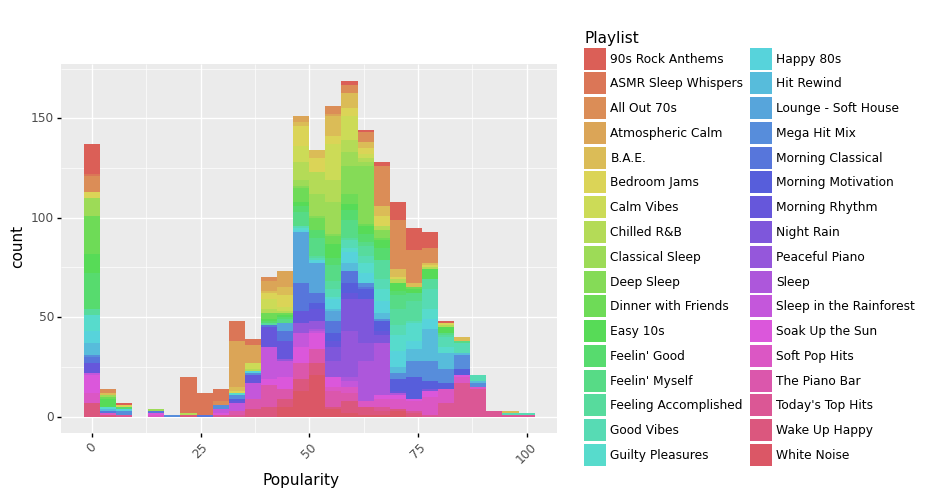

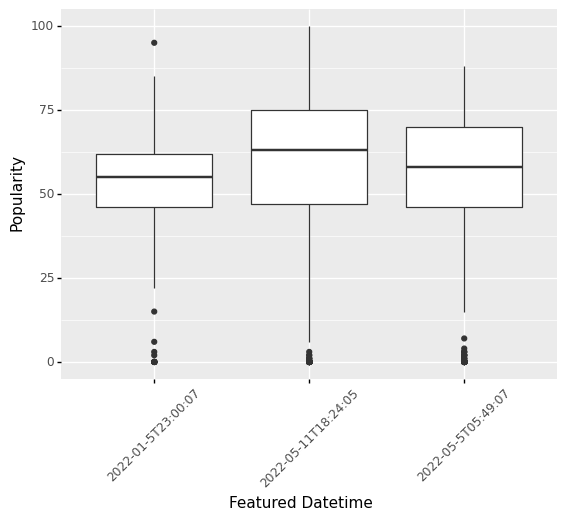

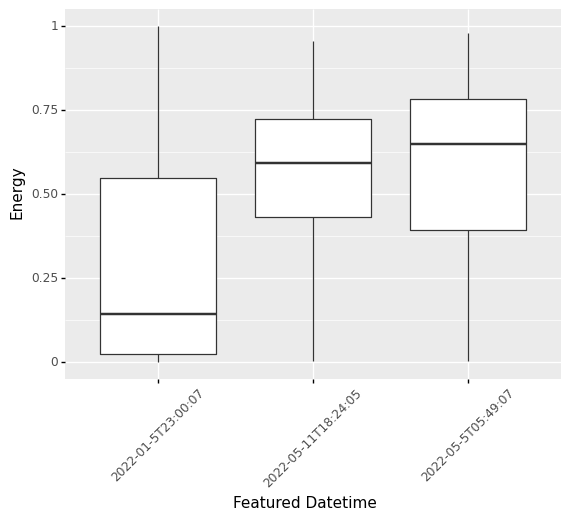

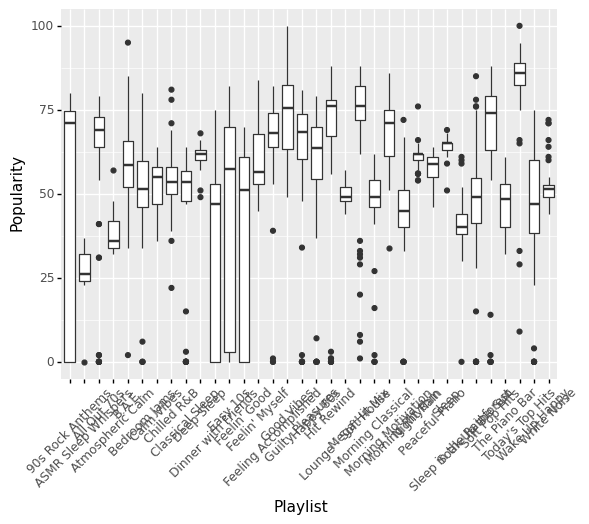

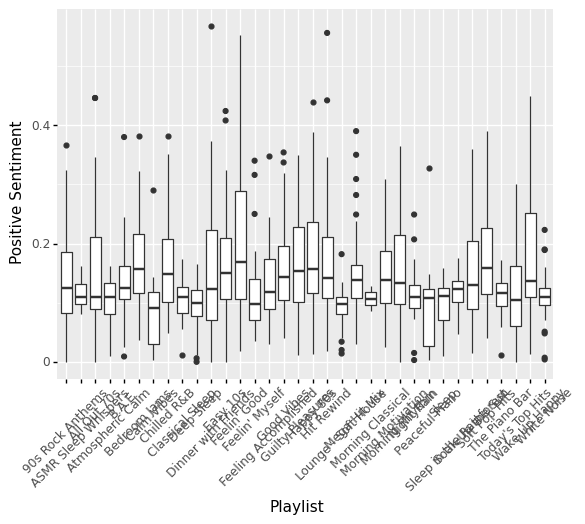

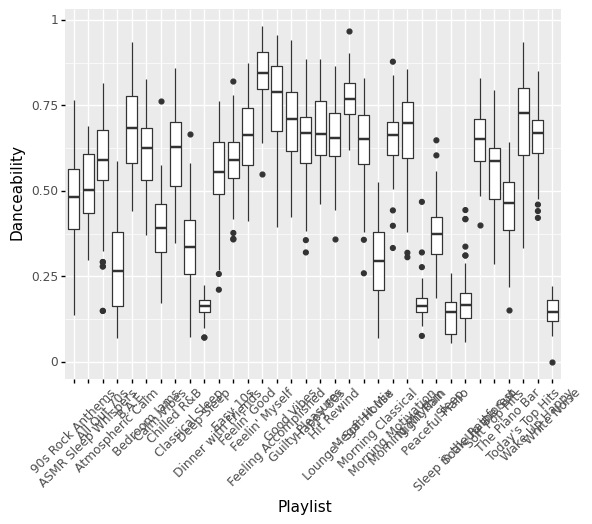

In [26]:
print(ggplot(AllTimeFeatured, aes("Popularity", fill = 'factor(playlist_name)')) 
      + geom_histogram()
     + guides(fill=guide_legend(title="Playlist"))
      + theme(axis_text_x=element_text(rotation=45)))

print(ggplot(AllTimeFeatured, aes(x = ("factor(featured_dt)"), y = "Popularity")) 
      + geom_boxplot()
     + xlab("Featured Datetime")
     + ylab("Popularity")
     + theme(axis_text_x=element_text(rotation=45)))

print(ggplot(AllTimeFeatured, aes(x = ("factor(featured_dt)"), y = "Energy")) 
      + geom_boxplot()
     + xlab("Featured Datetime")
     + ylab("Energy")
      + theme(axis_text_x=element_text(rotation=45)))

print(ggplot(AllTimeFeatured, aes(x = ("factor(playlist_name)"), y = "Popularity")) 
      + geom_boxplot()
     + xlab("Playlist")
     + ylab("Popularity")
      + theme(axis_text_x=element_text(rotation=45)))

print(ggplot(AllTimeFeatured, aes(x = ("factor(playlist_name)"), y = "track_positive_sentiment")) 
      + geom_boxplot()
     + xlab("Playlist")
     + ylab("Positive Sentiment")
      + theme(axis_text_x=element_text(rotation=45)))

print(ggplot(AllTimeFeatured, aes(x = ("factor(playlist_name)"), y = "Danceability")) 
      + geom_boxplot()
     + xlab("Playlist")
     + ylab("Danceability")
      + theme(axis_text_x=element_text(rotation=45)))